# Training on data such that there are 150 events with n tracks for n in [1,25].
# Testing on data such that there are 25 events with n tracks for n in [1,25].

In [2]:
!nvidia-smi

Tue Aug 15 15:00:17 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |   1355MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |   7735MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
# Author: Daniel Zurawski
# Author: Keshav Kapoor
# Organization: Fermilab
# Grammar: Python 3.6.1

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Choose either (1) or (2).
### (1) If you prefer a separate window for plots, uncomment the below.
#import matplotlib
#matplotlib.use('qt5agg')

### (2) If you prefer plots to display within the notebook, uncomment the below.
### WARNING: Plots suffer performance issues and will lag a bit.
%matplotlib notebook

import importlib
import keras # Neural network models
import pandas as pd # Data frames
import numpy as np  # numerical python
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


In [4]:
order   = ("r", "phi", "z")
n_noise = 0
code    = (order[0][0] + order[1][0] + order[2][0]).upper()

# True if you want to load from .npz file. False if you want to create your own data.
# This will NOT load from any .npz file. It will only load from .npz files stored using the
# loader.to_file() function.
load_from_file = True

# Name of files to save/load train and target data to/from.
file = "datasets/npz/UNIF-25T-175E-{0}-{1}N.npz".format(code, n_noise)
data, target = loader.from_file(file)
percent = 6/7  # What percent of the data should be used to train with.
bound   = int(data.shape[0] * percent)
train_data, train_target = data[:bound], target[:bound]
test_data,  test_target  = data[bound:], target[bound:]
print("Successfully loaded!")
print("train_data shape:   {0},\ntrain_target shape: {1}".format(train_data.shape, train_target.shape))
print("test_data shape:    {0},\ntest_target shape:  {1}".format(test_data.shape, test_target.shape))

Successfully loaded!
train_data shape:   (3750, 220, 3),
train_target shape: (3750, 220, 27)
test_data shape:    (625, 220, 3),
test_target shape:  (625, 220, 27)


In [5]:
# To be used when we define our model.
from keras.layers import TimeDistributed, Dense, LSTM, Activation
from keras.layers import Dropout, GRU, Bidirectional, Conv2D, Conv1D
from keras.layers import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Sequential

In [6]:
# It is time to define parameters for the model.
input_shape  = train_data.shape[1:] # Shape of an event.
num_classes  = train_target.shape[2] # Number of tracks per event
epochs       = 128
batch_size   = 64
valsplit     = 1/8
opt          = keras.optimizers.RMSprop(lr=0.001)

In [7]:
# If you decide to load this model from the file, don't run the cell immediately below this one.
# It'll overwrite the model that you just loaded in. This loaded-in model is the same as the below
# cell's model, except the loaded in model has been trained already.
model = keras.models.load_model("models/TRAIN-U25T150E-TEST-U25T25E-RPZ-0N.h5")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
###############
# Input Layer #
###############
model = Sequential()
model.add(Dropout(rate=1/16, input_shape=input_shape))

#################
# Hidden Layers #
#################
for _ in range(3):
    model.add(Bidirectional(
        GRU(
            units=300, 
            return_sequences=True,
            recurrent_dropout=1/8,
            #activation="tanh",
            dropout=1/8,
            implementation=2
        ),
        merge_mode="concat"
    ))
################
# Output Layer #
################
model.add(TimeDistributed(Dense(
    units=num_classes, 
    kernel_initializer="uniform", 
    activation="softmax"
)))

###############
# Compilation #
###############
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Print a summary of the model.
print("Epochs: {0}, Batch Size: {1}, Validation Split {2}%".format(
    epochs,
    batch_size,
    valsplit * 100
))
model.summary()

In [8]:
%%time

# The model was previously fitted on 128 epochs, so after running this cell,
# the model will have fitted on 256 epochs.

hist = model.fit (
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=valsplit,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath="models/TRAIN-U25T150E-TEST-U25T25E-{0}-{1}N.h5".format(code, n_noise),
        period=4
    )]
)
model.save("models/TRAIN-U25T150E-TEST-U25T25E-{0}-{1}N.h5".format(code, n_noise))

Train on 3281 samples, validate on 469 samples
Epoch 1/128
3281/3281 [==============================] - 52s - loss: 0.4338 - acc: 0.8333 - val_loss: 0.4884 - val_acc: 0.8174
Epoch 2/128
3281/3281 [==============================] - 51s - loss: 0.4253 - acc: 0.8368 - val_loss: 0.5033 - val_acc: 0.8176
Epoch 3/128
3281/3281 [==============================] - 52s - loss: 0.4296 - acc: 0.8351 - val_loss: 0.5202 - val_acc: 0.8145
Epoch 4/128
3281/3281 [==============================] - 51s - loss: 0.4328 - acc: 0.8336 - val_loss: 0.5063 - val_acc: 0.8158
Epoch 5/128
3281/3281 [==============================] - 52s - loss: 0.4205 - acc: 0.8385 - val_loss: 0.4856 - val_acc: 0.8213
Epoch 6/128
3281/3281 [==============================] - 52s - loss: 0.4219 - acc: 0.8381 - val_loss: 0.5062 - val_acc: 0.8181
Epoch 7/128
3281/3281 [==============================] - 52s - loss: 0.4243 - acc: 0.8372 - val_loss: 0.4935 - val_acc: 0.8178
Epoch 8/128
3281/3281 [==============================] - 52s - l

3281/3281 [==============================] - 51s - loss: 0.3018 - acc: 0.8864 - val_loss: 0.5387 - val_acc: 0.8122
Epoch 128/128
3281/3281 [==============================] - 51s - loss: 0.3029 - acc: 0.8859 - val_loss: 0.4855 - val_acc: 0.8318
CPU times: user 1h 49min 43s, sys: 4min 16s, total: 1h 54min
Wall time: 1h 53min 55s


# After fitting on 256 epochs:

In [8]:
guesses = model.predict(test_data)

<IPython.core.display.Javascript object>


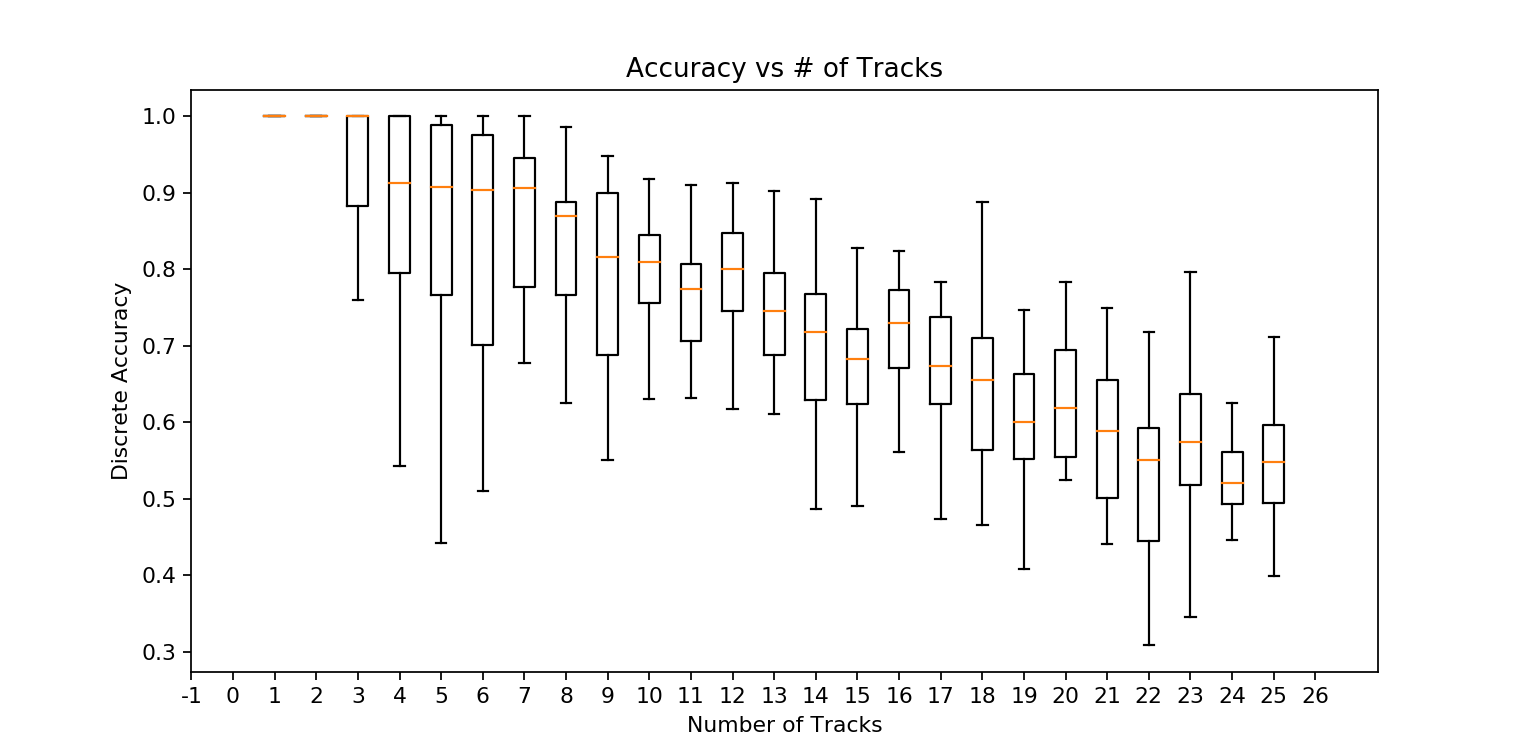

In [9]:
_ = metrics.accuracy_vs_tracks_boxplot(guesses, test_target, noise=(n_noise > 0))

<IPython.core.display.Javascript object>


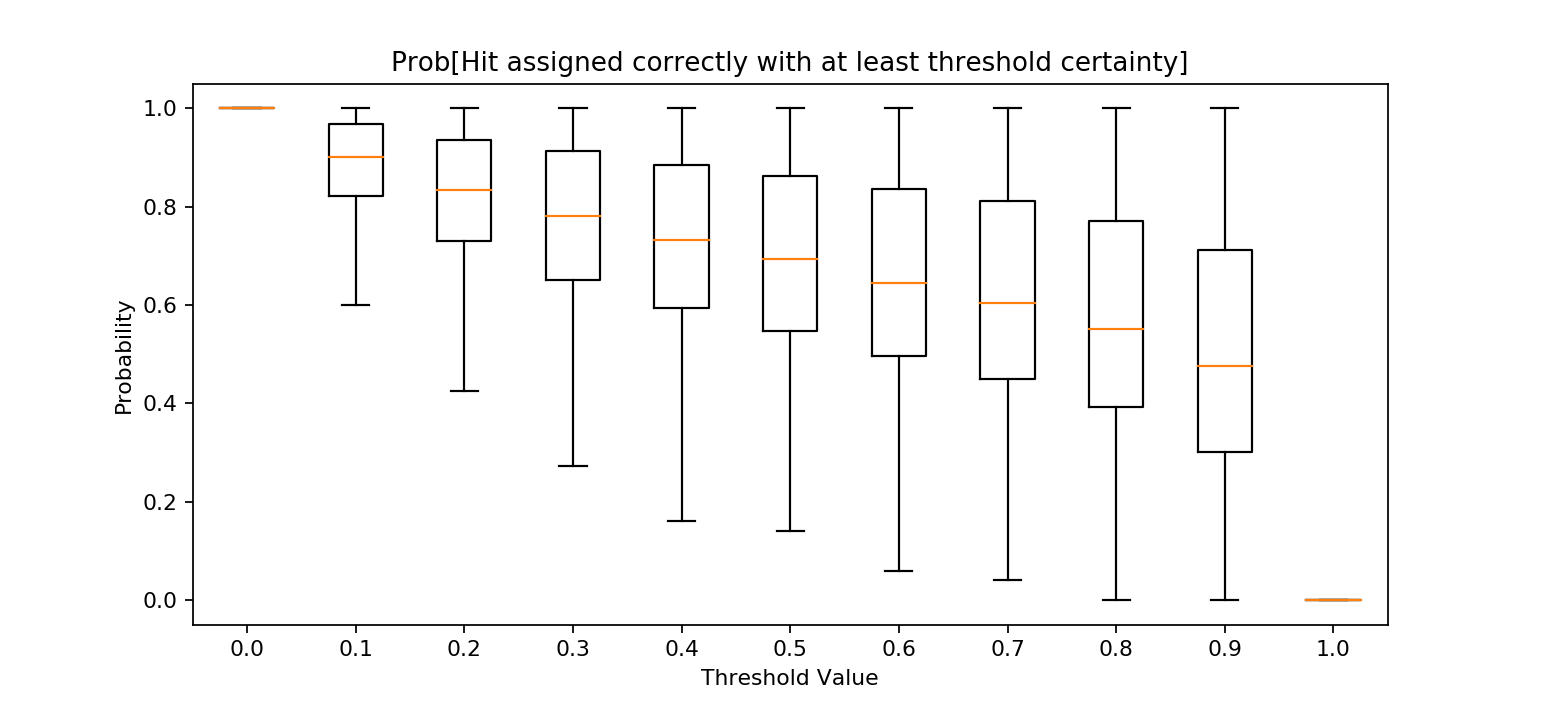

In [10]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
# Variation 1: Probability that hit was predicted correctly with certainty greater than or equal to threshold.
# Variation 2: Probability that hit was predicted incorrectly with certainty greater than or equal to threshold.
# Variation 3: Probability that hit was predicted to multiple tracks with certainties greater than or equal to threshold.
# Variation 4: utils.graph_losses([("history", hist)])Probability that hit was predicted to no track with certainty
# greater than or equal to threshold.
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="correct")

<IPython.core.display.Javascript object>


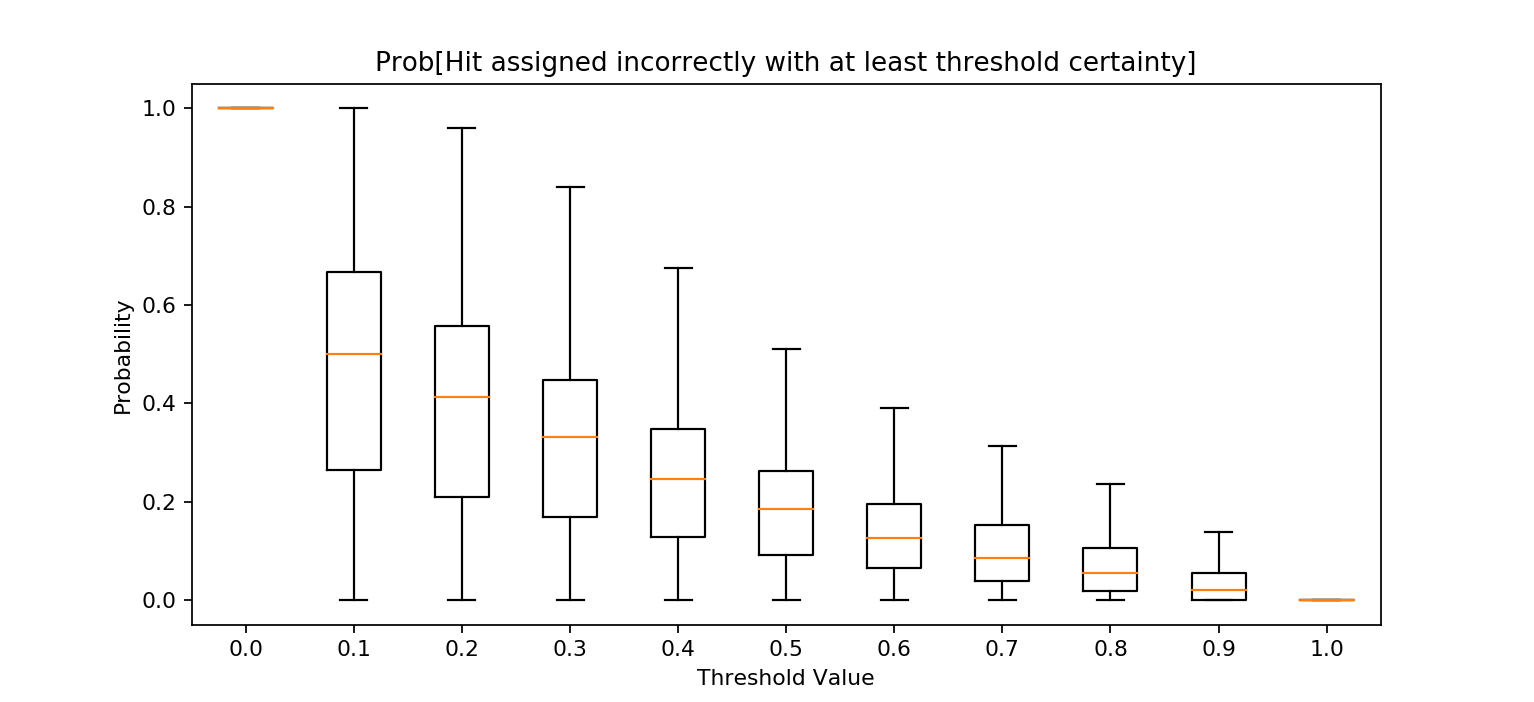

In [11]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="incorrect")

<IPython.core.display.Javascript object>


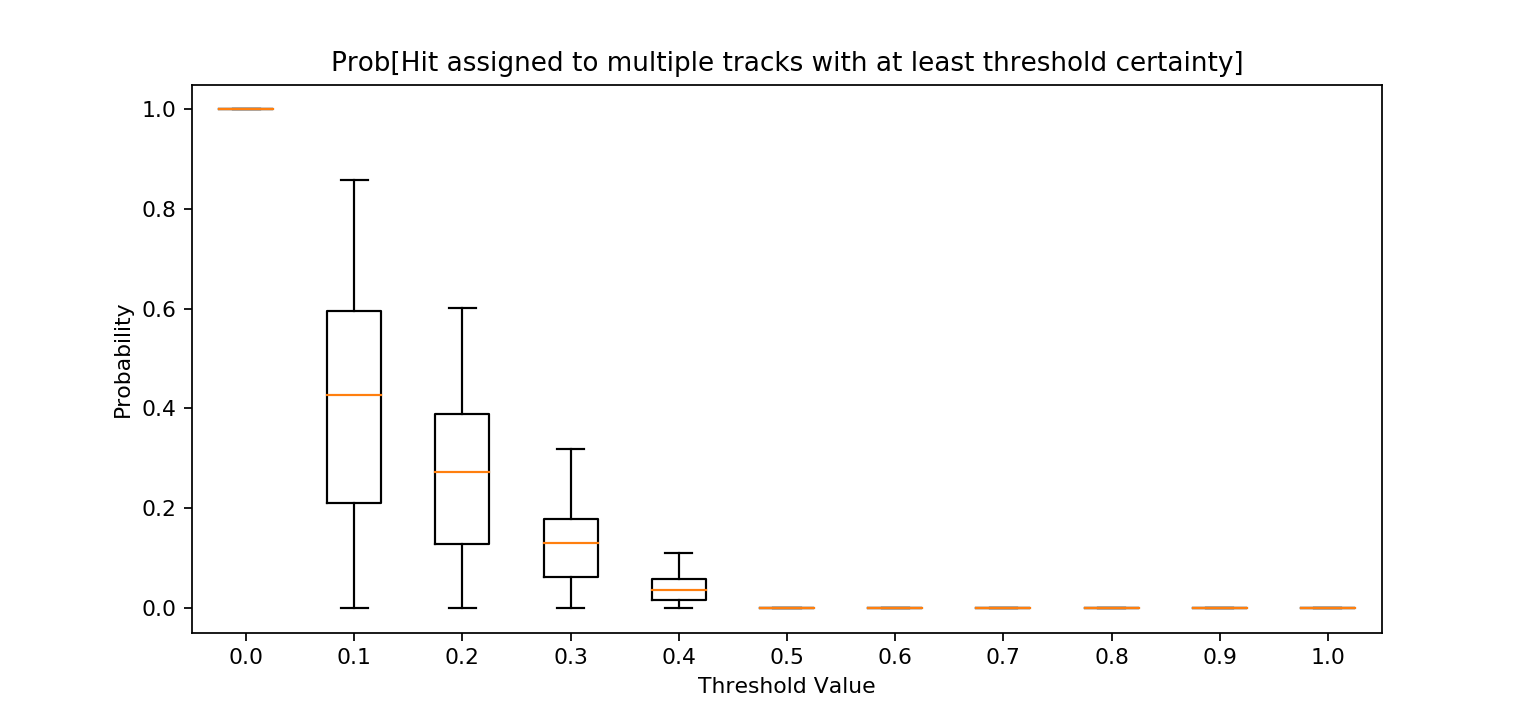

In [12]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="many")

<IPython.core.display.Javascript object>


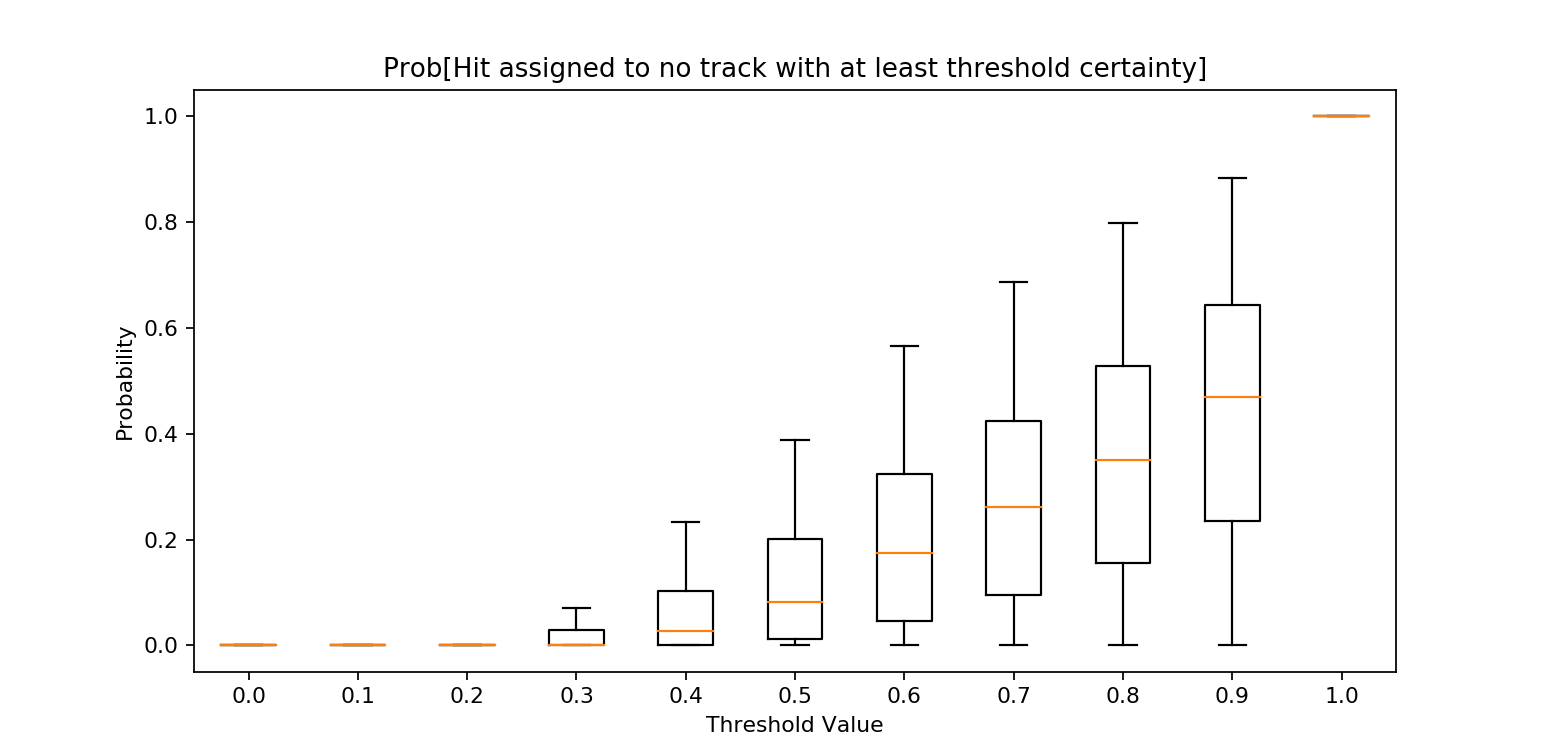

In [13]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="none")

<IPython.core.display.Javascript object>


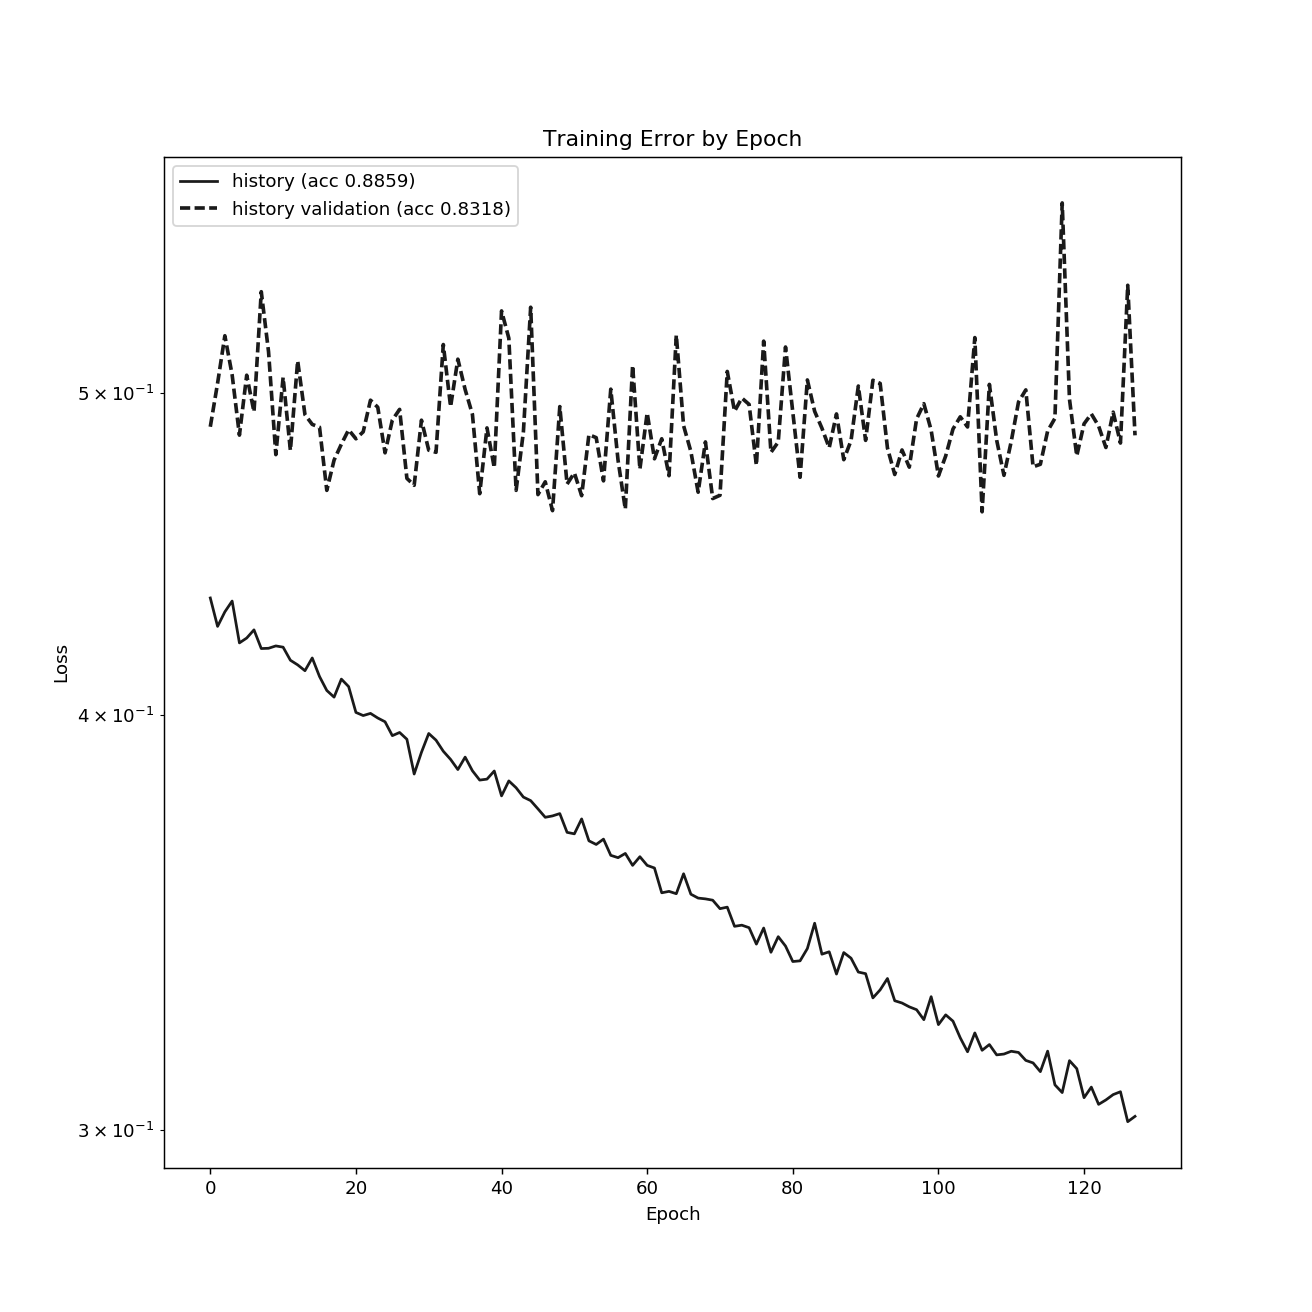

<IPython.core.display.Javascript object>


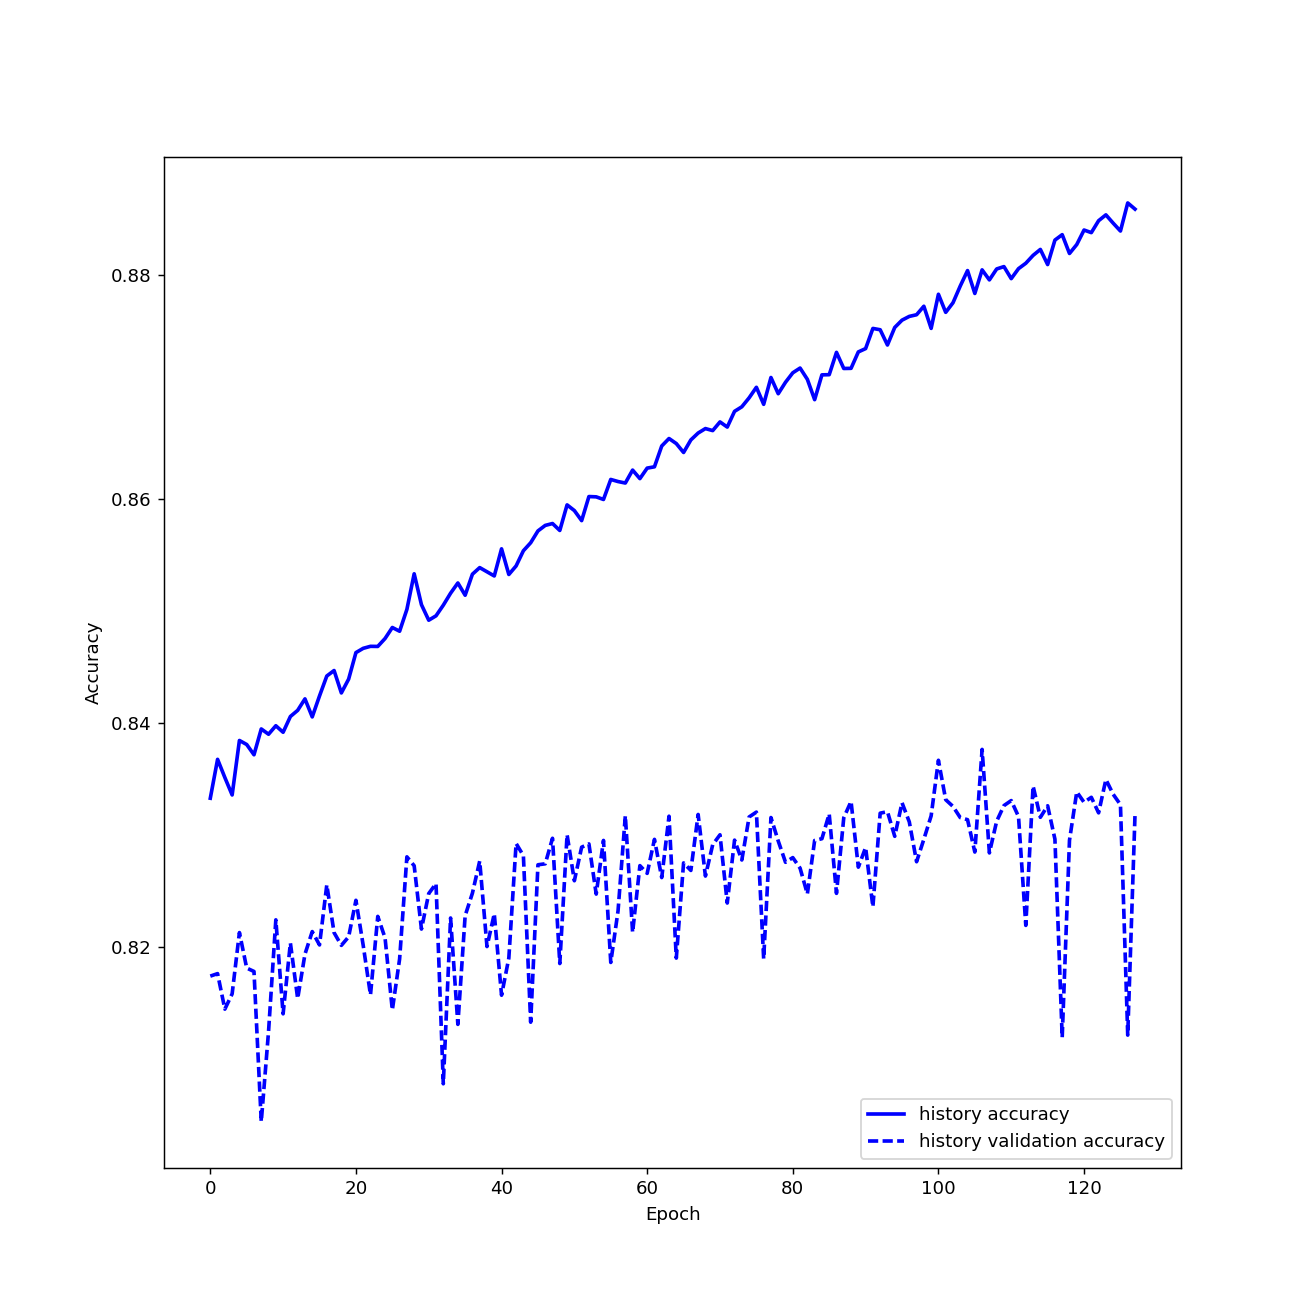

In [13]:
utils.graph_losses([("history", hist)])